In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy import stats
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

## Load trial data and PCs

In [10]:
with open(DATAFOLDER / "bazzino_data_for_frejus.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [11]:
pcafile = RESULTSFOLDER / "transformed_data_photo.pickle"

with open(pcafile, 'rb') as f:
    pca = dill.load(f)

pc1 = pca[:,0]
pca_data = pca[:, :3]

## Calculate trial distances based on clusters and PCs

In [12]:
# calculate centroids
cluster_0_centroid = pca_data[x_array.cluster_photo == 0].mean(axis=0)
cluster_1_centroid = pca_data[x_array.cluster_photo == 1].mean(axis=0)


## First, to work out projections
# Step 2: Define the cluster separation vector
cluster_vector = cluster_0_centroid - cluster_1_centroid

# Step 3: Project each observation onto the cluster vector
# Normalize the cluster vector
cluster_vector_norm = cluster_vector / np.linalg.norm(cluster_vector)
# Compute projections
projections = np.dot(pca_data - cluster_1_centroid, cluster_vector_norm)

# Step 4: Normalize the projections to range between 0 and 1
min_projection = projections.min()
max_projection = projections.max()
normalized_projections = (projections - min_projection) / (max_projection - min_projection)

x_array = x_array.assign(clusterness_photo=normalized_projections)


## Second to work out Euclidian distances
# Stack centroids into a matrix
centroids = np.vstack([cluster_0_centroid, cluster_1_centroid])

# Calculate all distances at once using cdist
# This creates a matrix where each row is an observation and each column is a centroid
distances = cdist(pca_data, centroids, metric='euclidean')

distances_diff = distances[:, 1] - distances[:, 0]

x_array = x_array.assign(euclidean_diff=distances_diff)

In [13]:
# to show eligible rats for this fitting
x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").id.unique()

array(['PB26', 'PB27', 'PB30', 'PB31', 'PB46', 'PB48', 'PB71', 'PB72',
       'PB73', 'PB75'], dtype=object)

     id         A         L   x0_norm    x0_orig          k      model  \
0  PB26  0.024489  0.923220 -0.095859  22.644355 -10.000000  logistic4   
1  PB27       NaN       NaN       NaN        NaN        NaN       None   
2  PB30  0.083253  1.030909 -0.842827  12.080631 -10.000000  logistic4   
3  PB31 -0.027289  0.986766 -0.035364  23.499883  -4.822829  logistic4   
4  PB46  0.065452  0.649679 -0.304863  19.688587 -10.000000  logistic4   
5  PB48  0.020504  0.400000 -3.000000 -18.426407 -10.000000  logistic4   
6  PB71  0.048542  0.949933 -0.742174  13.504078 -10.000000  logistic4   
7  PB72  0.068427  1.040850 -0.885365  11.479045 -10.000000  logistic4   
8  PB73 -0.012700  0.979151 -0.475981  17.268613 -10.000000  logistic4   
9  PB75 -0.100000  0.622672  0.146080  26.065888  -1.528708  logistic4   

   success        note  
0     True              
1    False  fit failed  
2     True              
3     True              
4     True              
5     True              
6     True

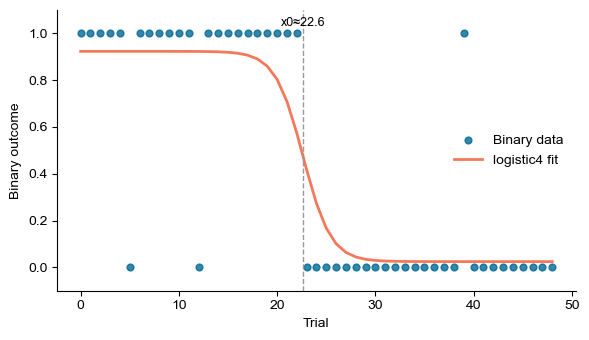

In [ ]:
# Robust logistic fits for binary/near-binary data (handles optional offset)

# 3-parameter logistic (no baseline offset)
def logistic3(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# 4-parameter logistic (baseline offset A)
def logistic4(x, A, L, x0, k):
    return A + (L - A) / (1 + np.exp(-k * (x - x0)))


def _normalize_x(x):
    x = np.asarray(x, dtype=float)
    m, s = float(np.mean(x)), float(np.std(x))
    if not np.isfinite(s) or s == 0:
        s = 1.0
    return (x - m) / s, m, s


def _clip_y(y):
    y = np.asarray(y, dtype=float)
    return np.clip(y, 1e-4, 1 - 1e-4)


def fit_logistic_per_series(y, x=None, prefer_4p=True, direction=None, maxfev=60000):
    """
    Fit a logistic curve to binary/near-binary data with robust inits and bounds.
    - prefer_4p: try 4-parameter (with baseline) first, then fallback to 3-parameter
    - direction: None to infer from corr(x,y); 'increasing' or 'decreasing' to enforce k sign
    Returns dict with keys: {'model','params','y_hat','x0_orig','success','note'}
    """
    if x is None:
        x = np.arange(len(y), dtype=float)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Normalize x for stabler k/x0 estimation
    x_norm, x_mean, x_std = _normalize_x(x)
    y_clip = _clip_y(y)

    # Initial guesses from data
    y_min, y_max = float(np.min(y_clip)), float(np.max(y_clip))
    A_init = y_min
    L_init = y_max
    x0_init = 0.0

    # k sign from direction or correlation
    if direction is None:
        try:
            c = float(np.corrcoef(x, y_clip)[0, 1])
        except Exception:
            c = 0.0
        if not np.isfinite(c):
            c = 0.0
        sign = 1.0 if c >= 0 else -1.0
    else:
        sign = 1.0 if direction == 'increasing' else -1.0

    k_mags = [0.5, 1.0, 2.0]

    def try_fit(func, p0_list, bounds, n_params):
        best = None
        best_rss = np.inf
        for p0 in p0_list:
            try:
                popt, _ = curve_fit(func, x_norm, y_clip, p0=p0, bounds=bounds, maxfev=maxfev)
                y_hat = func(x_norm, *popt)
                rss = float(np.sum((y_clip - y_hat) ** 2))
                if rss < best_rss:
                    best_rss, best = rss, (popt, y_hat)
            except Exception:
                continue
        return best

    # 4-parameter attempt
    res4 = None
    if prefer_4p:
        p0s_4 = [[A_init, L_init, x0_init, sign * km] for km in k_mags]
        # Keep values sensible for binary-ish data
        bnds_4 = ([ -0.1,  0.4, -3.0, -10.0],
                  [  0.6,  1.6,  3.0,  10.0])
        res4 = try_fit(logistic4, p0s_4, bnds_4, 4)

    # 3-parameter fallback or primary
    res3 = None
    p0s_3 = [[L_init, x0_init, sign * km] for km in k_mags]
    bnds_3 = ([0.4, -3.0, -10.0], [1.6, 3.0, 10.0])
    res3 = try_fit(logistic3, p0s_3, bnds_3, 3)

    # Choose result: prefer successful 4p; otherwise 3p
    if res4 is not None:
        popt, y_hat = res4
        # x0 already in normalized units; convert to original units for reporting
        A, L, x0n, k = map(float, popt)
        x0_orig = x0n * x_std + x_mean
        return {
            'model': 'logistic4',
            'params': {'A': A, 'L': L, 'x0_norm': x0n, 'x0_orig': x0_orig, 'k': k},
            'y_hat': y_hat,
            'x0_orig': x0_orig,
            'success': True,
            'note': ''
        }
    elif res3 is not None:
        popt, y_hat = res3
        L, x0n, k = map(float, popt)
        x0_orig = x0n * x_std + x_mean
        return {
            'model': 'logistic3',
            'params': {'L': L, 'x0_norm': x0n, 'x0_orig': x0_orig, 'k': k},
            'y_hat': y_hat,
            'x0_orig': x0_orig,
            'success': True,
            'note': '4p failed; used 3p'
        }
    else:
        return {'model': None, 'params': {}, 'y_hat': None, 'x0_orig': np.nan, 'success': False, 'note': 'fit failed'}


# Example usage on deplete & 45NaCl subset (binary/inverted cluster_photo)
df_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").copy()
all_fits = []

for rat in df_dep_45.id.unique():
    sig = df_dep_45.loc[df_dep_45.id == rat, 'cluster_photo'].to_numpy()
    # Make binary: invert if needed (original code inverted)
    y = np.logical_not(sig).astype(int)
    x = np.arange(len(y), dtype=float)

    fit = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')
    all_fits.append({ 'id': rat, **fit['params'], 'model': fit['model'], 'x0_orig': fit['x0_orig'], 'success': fit['success'], 'note': fit['note'] })

fits_df = pd.DataFrame(all_fits)
print(fits_df)

# Quick visualization for one rat
example_rat = df_dep_45.id.unique()[0]
sig = df_dep_45.loc[df_dep_45.id == example_rat, 'cluster_photo'].to_numpy()
y = np.logical_not(sig).astype(int)
x = np.arange(len(y), dtype=float)
res = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')

plt.figure(figsize=(6, 3.5))
plt.scatter(x, y, s=24, color='#016895', alpha=0.8, label='Binary data')
if res['y_hat'] is not None:
    plt.plot(x, res['y_hat'], color='#F4795B', lw=2, label=f"{res['model']} fit")
    if np.isfinite(res['x0_orig']):
        plt.axvline(res['x0_orig'], color='#999', ls='--', lw=1)
        plt.text(res['x0_orig'], 1.02, f"x0≈{res['x0_orig']:.1f}", ha='center', va='bottom', fontsize=9)
plt.ylim(-0.1, 1.1)
plt.xlabel('Trial')
plt.ylabel('Binary outcome')
sns.despine()
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

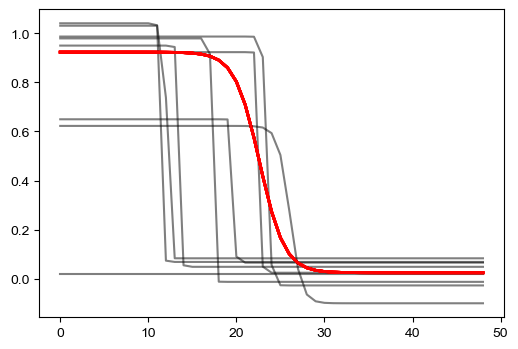

In [35]:
f, ax = plt.subplots(figsize=(6, 4))

for fit in fits_df.iterrows():
    if not fit[1].success:
        continue
    res = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')

    ax.plot(x, logistic4(x, fit[1].A, fit[1].L, fit[1].x0_orig, fit[1].k), color="k", alpha=0.5)
    ax.plot(x, res['y_hat'], color="r", linewidth=2)

In [ ]:
for fit in fits_df.itertuples():
    print(fit)
    if fit[0] < 0.5:
        continue
    ax.plot(x, logistic(x, *fit[:-1]), label="Fitted Logistic Function", linestyle="--", color=colors[2])
    
sns.despine(ax=ax)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Probability of Cluster 1")

x0 = np.array(all_logistic_fits)[:,1]

ax.plot(x0, [1.1]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 1.1, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [1.05, 1.15], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 1.16, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.02, 1.1])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)


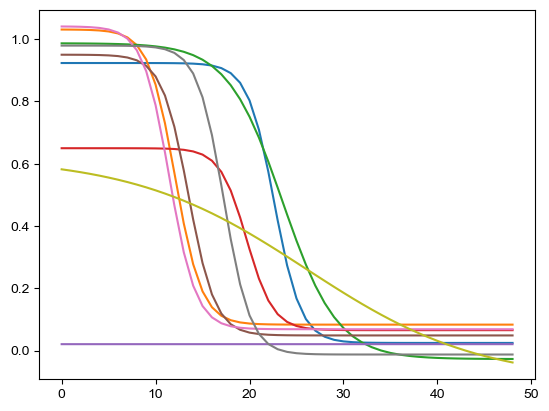

In [37]:
f, ax = plt.subplots()

for rat in df_dep_45.id.unique():
    sig = df_dep_45.loc[df_dep_45.id == rat, 'cluster_photo'].to_numpy()
    # Make binary: invert if needed (original code inverted)
    y = np.logical_not(sig).astype(int)
    x = np.arange(len(y), dtype=float)

    fit = fit_logistic_per_series(y, x=x, prefer_4p=True, direction='decreasing')
    all_fits.append({ 'id': rat, **fit['params'], 'model': fit['model'], 'x0_orig': fit['x0_orig'], 'success': fit['success'], 'note': fit['note'] })
    if fit["success"]:
        ax.plot(x, fit["y_hat"])


id: <built-in function id>, params: [  0.91304348  22.65402374 -27.94407776]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [ 1.01227259 12.45730322 -0.90807663]
id: <built-in function id>, params: [ 0.98251587 23.36861632 -0.36059154]
id: <built-in function id>, params: [  0.65        19.67606834 -27.3883299 ]
id: <built-in function id>, params: [ 7.66394048e-09  4.99999998e+00 -9.99999943e-01]
id: <built-in function id>, params: [  0.92857143  13.74012907 -37.34739805]
id: <built-in function id>, params: [  1.          11.50046692 -21.57905387]
id: <built-in function id>, params: [  0.94444444  17.73653451 -39.43057602]
id: <built-in function id>, params: [ 0.61467225 23.00367072 -0.12792541]
[  0.91304348  22.65402374 -27.94407776   0.76687161]
[-1.95833480e-18  4.99999999e+00 -9.99999984e-01            -inf]
[ 1.01227259 12.45730322 -0.90807663  0.64260504]
[ 0.98251587 23.36861632 -0.36059154  0.78410081]
[

C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3203773105.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))


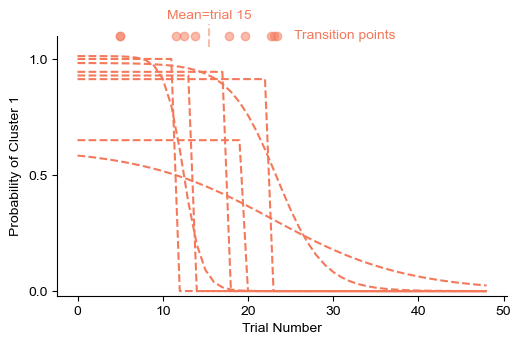

In [18]:
all_logistic_fits = []

df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

for rat in df2_dep_45.id.unique():
    signal = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'").cluster_photo
    y = np.logical_not(signal).astype(int) # inverted signal
    
    x = np.arange(len(signal))

    try:
        popt, _ = curve_fit(logistic, x, y, p0=[1, 5, -1])  # Initial guesses for L, x0, k

        print(f"id: {id}, params: {popt}")

        y_fit = logistic(x, *popt)
        ss_res = np.sum((y - y_fit) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

    except RuntimeError as e:
        print(f"Could not fit logistic for id {id}: {e}")
        r_squared = np.nan

    all_logistic_fits.append(np.concatenate([popt, [r_squared]]))

x = np.arange(len(signal))
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
     
f, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'left': 0.2, 'right': 0.95, 'top': 0.85, 'bottom': 0.2})

for fit in all_logistic_fits:
    print(fit)
    if fit[0] < 0.5:
        continue
    ax.plot(x, logistic(x, *fit[:-1]), label="Fitted Logistic Function", linestyle="--", color=colors[2])
    
sns.despine(ax=ax)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Probability of Cluster 1")

x0 = np.array(all_logistic_fits)[:,1]

ax.plot(x0, [1.1]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 1.1, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [1.05, 1.15], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 1.16, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.02, 1.1])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)


In [19]:
df_params_clusters = pd.DataFrame(data = np.array(all_logistic_fits),
                                columns = ["L", "x0", "k", "r"])

df_params_clusters.insert(0, "id", df2_dep_45.id.unique())

lower, upper = 0, 50
df_params_clusters = df_params_clusters[
    (df_params_clusters['x0'] >= lower) & (df_params_clusters['x0'] <= upper)
    & (df_params_clusters['r'] >= 0.3)
    
].reset_index(drop=True)

In [20]:
df_params_clusters

,id,L,x0,k,r
0,PB26,0.913043,22.654024,-27.944078,0.766872
1,PB30,1.012273,12.457303,-0.908077,0.642605
2,PB31,0.982516,23.368616,-0.360592,0.784101
3,PB46,0.650000,19.676068,-27.388330,0.370686
4,PB71,0.928571,13.740129,-37.347398,0.718627
5,PB72,1.000000,11.500467,-21.579054,0.711765
6,PB73,0.944444,17.736535,-39.430576,0.914931


## Function to get fitted params using different input data

In [21]:
def fit_logistic_for_all_rats(data, input_parameter, p0=[1, 5, -1], invert_signal=False):
    all_logistic_fits = []

    for rat in data.id.unique():
        signal = data.query("id == @rat")[input_parameter]

        if invert_signal:
            y = np.logical_not(signal).astype(int)
        
        x = np.arange(len(signal))

        try:
            popt, _ = curve_fit(logistic, x, y, p0=p0)  # Initial guesses for L, x0, k

            print(f"id: {id}, params: {popt}")

            y_fit = logistic(x, *popt)
            ss_res = np.sum((y - y_fit) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)

        except RuntimeError as e:
            print(f"Could not fit logistic for id {id}: {e}")
            r_squared = np.nan

        all_logistic_fits.append(np.concatenate([popt, [r_squared]]))

    return all_logistic_fits

def get_fitted_params(data, input_parameter, p0=[1, 5, -1], invert_signal=False):
    
    
    all_logistic_fits = fit_logistic_for_all_rats(data, input_parameter, p0, invert_signal)

    df_params = pd.DataFrame(data = np.array(all_logistic_fits),
                                    columns = ["L", "x0", "k", "r"])

    df_params.insert(0, "id", df2_dep_45.id.unique())

    lower, upper = 0, 50
    df_params = df_params[
        (df_params['x0'] >= lower) & (df_params['x0'] <= upper)
        & (df_params['r'] >= 0.3)
                        ].reset_index(drop=True)

    return df_params

df_params_clusters = get_fitted_params(df2_dep_45, "cluster_photo", p0=[1, 5, -1], invert_signal=True)

id: <built-in function id>, params: [  0.91304348  22.65402374 -27.94407776]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [ 1.01227259 12.45730322 -0.90807663]
id: <built-in function id>, params: [ 0.98251587 23.36861632 -0.36059154]
id: <built-in function id>, params: [  0.65        19.67606834 -27.3883299 ]
id: <built-in function id>, params: [ 7.66394048e-09  4.99999998e+00 -9.99999943e-01]
id: <built-in function id>, params: [  0.92857143  13.74012907 -37.34739805]
id: <built-in function id>, params: [  1.          11.50046692 -21.57905387]
id: <built-in function id>, params: [  0.94444444  17.73653451 -39.43057602]
id: <built-in function id>, params: [ 0.61467225 23.00367072 -0.12792541]


C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\1440886406.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_11536\3184824449.py:3: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))


In [22]:
df_params_clusters

,id,L,x0,k,r
0,PB26,0.913043,22.654024,-27.944078,0.766872
1,PB30,1.012273,12.457303,-0.908077,0.642605
2,PB31,0.982516,23.368616,-0.360592,0.784101
3,PB46,0.650000,19.676068,-27.388330,0.370686
4,PB71,0.928571,13.740129,-37.347398,0.718627
5,PB72,1.000000,11.500467,-21.579054,0.711765
6,PB73,0.944444,17.736535,-39.430576,0.914931


In [ ]:
df_params_clusterness = get_fitted_params(
    df2_dep_45, "clusterness_photo",
    p0=[1, 5, -1],
    invert_signal=False)

In [8]:
def realigned_trials(x_array, df_fitted_params, verbose=True):

# Realigning behavioral data to dopamine transitions
    realigned_trials = []

    for rat in x_array.id.unique():
        
        x_array_r = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'")

        if rat not in df_fitted_params.id.unique():
            if verbose:
                print(f"Rat {rat} not found in fitted parameters, skipping.")
            realigned_trials.append([np.nan] * len(x_array_r.trial))
        else:
            transition_point = int(df_fitted_params.query("id == @rat").x0.values[0])
            realigned_trials.append(x_array_r.trial - transition_point)

    return (
        x_array
        .assign(trial_aligned=tp.flatten_list(realigned_trials))
        .dropna()
        .reset_index(drop=True)
        # .astype(int)  # Ensure the trial_aligned column is of integer type
        )
    
        
        # Update the original DataFrame
        # print(len(x_array.loc[x_array.id == rat, 'trial_aligned']))
        # x_array.loc[x_array.id == rat, 'trial_aligned'] = x_array_r['trial_aligned'].values
df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

z = realigned_trials(df2_dep_45, df_fitted_params)

Rat PB27 not found in fitted parameters, skipping.
Rat PB48 not found in fitted parameters, skipping.
Rat PB75 not found in fitted parameters, skipping.


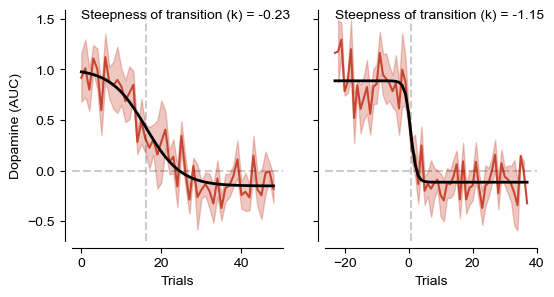

In [10]:
# make dopamine figure with trials and sigmoidal fit

def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

def plot_auc_and_sigmoid(df, column, ax=None, first_trial=0, include_steepness=True):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    sd = df.groupby(column).std(numeric_only=True).auc_snips.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[3])
    ax.fill_between(x, y-sem, y+sem, color=colors[3], alpha=0.3)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color="k", lw=2)
        if include_steepness:
            ax.text(first_trial, 1.5, "Steepness of transition (k) = {:.2f}".format(popt[2]))
    except:
        print("Failed to fit")

    ax.axhline(0, color="k", linestyle="--", alpha=0.2)
    ax.axvline(popt[1], color="k", linestyle="--", alpha=0.2)
    sns.despine(ax=ax, offset=5)

    ax.set_ylabel("Dopamine (AUC)")
    ax.set_xlabel("Trials")


f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
plot_auc_and_sigmoid(z, "trial", ax=ax[0])
plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min())

ax[1].set_ylabel("")

f.savefig(FIGSFOLDER / "realigned_transitions.png")



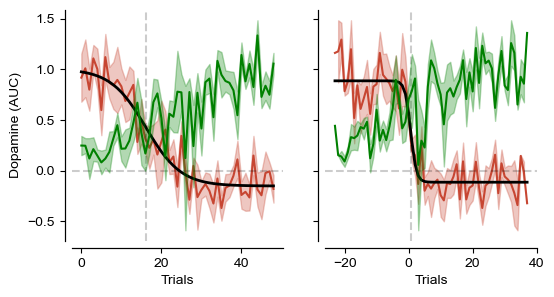

In [15]:
def plot_realigned_behaviour(df, column, ax=None, first_trial=0):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).auc_vel
    sd = df.groupby(column).std(numeric_only=True).auc_vel.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color="green")
    ax.fill_between(x, y-sem, y+sem, color="green", alpha=0.3)
    
    sns.despine(ax=ax, offset=5)
    ax.set_yticks([])

    # ax.set_ylabel("Dopamine (AUC)")
    # ax.set_xlabel("Trials")

f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
plot_auc_and_sigmoid(z, "trial", ax=ax[0], include_steepness=False)
plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min(), include_steepness=False)

ax[1].set_ylabel("")

ax2 = ax[0].twinx()
plot_realigned_behaviour(z, "trial",ax=ax2)
f.savefig(FIGSFOLDER / "realigned_transitions_behav1.png")

ax3 = ax[1].twinx()
plot_realigned_behaviour(z, "trial_aligned",ax=ax3, first_trial=z.trial_aligned.min())
f.savefig(FIGSFOLDER / "realigned_transitions_behav2.png")
    

In [22]:
print(df2_dep_45.id.unique())
print(df_fitted_params_shuffled.id.unique())

['PB26' 'PB27' 'PB30' 'PB31' 'PB46' 'PB48' 'PB71' 'PB72' 'PB73' 'PB75']
['PB26' 'PB30' 'PB31' 'PB46' 'PB71' 'PB72' 'PB73']


In [11]:
# shuffle rows in df_fitted
# run realignment
# fit sigmoidal and add to list
# plot hist of shuffled
# calc proportion that are greater

def fit_sigmoid(df, column):
    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return np.nan

df_fitted_params

real_k = fit_sigmoid(z, "trial_aligned")[2]

num_repeats = 1000
shuffled_k = np.zeros(num_repeats)
for i in range(num_repeats):
    shuffled_x0s = df_fitted_params.x0.values
    np.random.shuffle(shuffled_x0s)
    df_fitted_params_shuffled = df_fitted_params.assign(x0=shuffled_x0s)
    z_temp = realigned_trials(df2_dep_45, df_fitted_params_shuffled, verbose=False)
    shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned")[2]

print(real_k)



-1.1461410399049892


Text(0.5, 0, 'Steepness of transition (k)')

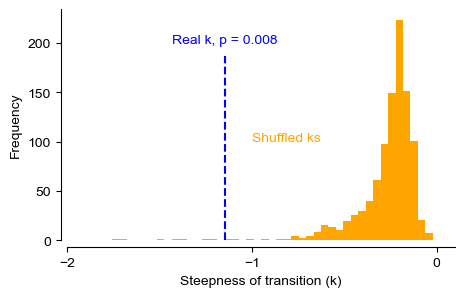

In [36]:
color_shuf = "orange"
color_real = "blue"

bins = np.linspace(-2, 2, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuffled_k, bins=bins, color=color_shuf)
ax.axvline(real_k, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-2, 0.1)
ax.set_xticks([-2, -1, 0])
ax.text(real_k, 200,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuffled_k > real_k) / num_repeats),
        ha="center",
        color=color_real)

ax.text(-1, 100, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

In [ ]:
# to calculate difference before and after to see whether realigning worked

transition = 0
before = z.query("trial_aligned < @transition").auc_vel.mean()
after = z.query("trial_aligned >= @transition").auc_vel.mean()
print(f"Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")

In [ ]:
for transition in np.arange(1, 48):
    before = z.query("trial < @transition").auc_vel.mean()
    after = z.query("trial >= @transition").auc_vel.mean()
    print(f"{transition}, Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")